# Addictive Model

## Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus

## Import Dataset

In [2]:
file_path = '../data/food_data_cleaned.xlsx'
food_data = pd.ExcelFile(file_path)

In [3]:
data = food_data.parse('Sheet1')
data.head()

,Food Name,Energy (KJ/100g),Sugars (g/100g),Saturated Fat (g/100g),Salt (g/100g),Proteins (g/100g),Fiber (g/100g),Fruit/Veg (%),Nutri-Score,Ecoscore
0,Nutella,2252.0,56.3,10.6,0.107,6.3,0.0,0.0,e,31
1,Sésame,1961.0,17.0,2.0,0.380,10.0,4.6,0.0,b,57
2,Alvalle Gazpacho l'original,168.0,3.3,0.4,0.620,0.9,1.2,0.0,a,82
3,70% Cacao noir intense,2350.0,30.0,24.0,0.100,9.5,0.0,0.0,e,29
4,Noir Excellence 90%,2477.0,7.0,30.0,0.030,10.0,0.0,0.0,d,29


Preprocessing

In [4]:
nutri_score_mapping = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}
data['Nutri-Score'] = data['Nutri-Score'].map(nutri_score_mapping)

In [5]:
# scaler = MinMaxScaler()
# scaled_columns = ["Energy (KJ/100g)", "Sugars (g/100g)", "Saturated Fat (g/100g)", 
#                   "Salt (g/100g)", "Proteins (g/100g)", "Fiber (g/100g)", "Ecoscore"]
# data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

In [6]:
data

,Food Name,Energy (KJ/100g),Sugars (g/100g),Saturated Fat (g/100g),Salt (g/100g),Proteins (g/100g),Fiber (g/100g),Fruit/Veg (%),Nutri-Score,Ecoscore
0,Nutella,2252.0,56.3,10.6,0.107,6.3,0.0,0.0,1,31
1,Sésame,1961.0,17.0,2.0,0.380,10.0,4.6,0.0,4,57
2,Alvalle Gazpacho l'original,168.0,3.3,0.4,0.620,0.9,1.2,0.0,5,82
3,70% Cacao noir intense,2350.0,30.0,24.0,0.100,9.5,0.0,0.0,1,29
4,Noir Excellence 90%,2477.0,7.0,30.0,0.030,10.0,0.0,0.0,2,29
...,...,...,...,...,...,...,...,...,...,...
711,Tortilla Nachips Original,2057.0,0.5,2.2,0.490,7.8,6.0,0.0,4,72
712,Tomato ketchup,435.0,22.8,0.1,1.800,1.2,0.0,0.0,2,85
713,Cola Cao El Original,288.0,9.1,1.1,0.120,3.4,0.5,0.0,4,0
714,Gnocchi à poêler,801.0,1.5,0.3,1.100,5.0,2.6,0.0,4,82


## Weighted Model

### Split Data

In [7]:
features = ['Energy (KJ/100g)', 'Proteins (g/100g)', 'Salt (g/100g)', 'Fiber (g/100g)', 'Saturated Fat (g/100g)', 'Sugars (g/100g)']
X = data[features]
y = data[['Nutri-Score']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

data = X_train
data['nutriscore'] = y_train['Nutri-Score']

data_test = X_test
data_test['nutriscore'] = y_test['Nutri-Score']

### Bucket Creation

In [9]:
def create_buckets(data, criterion, precision, eps):
    num_buckets = int((data[criterion].max() + eps - data[criterion].min()) / precision)
    max_value = data[criterion].max() + eps
    min_value = data[criterion].min()
    real_precision = (max_value - min_value) / num_buckets
    
    buckets = []
    left_thresh = min_value
    for i in range(num_buckets):
        buckets.append((left_thresh, left_thresh+real_precision))
        left_thresh = left_thresh+real_precision

    return buckets

In [10]:
def create_buckets_by_quantiles(df, column, num_buckets):
    quantiles = df[column].quantile([i / num_buckets for i in range(num_buckets + 1)]).values
    quantiles[-1] = max(quantiles[-1], df[column].max())
    buckets = [(quantiles[i], quantiles[i + 1]) for i in range(len(quantiles) - 1)]
    return buckets

buckets = {}
buckets['Energy (KJ/100g)'] = create_buckets_by_quantiles(data, 'Energy (KJ/100g)', num_buckets=10)
buckets['Saturated Fat (g/100g)'] = create_buckets_by_quantiles(data, 'Saturated Fat (g/100g)', num_buckets=5)
buckets['Sugars (g/100g)'] = create_buckets_by_quantiles(data, 'Sugars (g/100g)', num_buckets=6)
buckets['Fiber (g/100g)'] = create_buckets_by_quantiles(data, 'Fiber (g/100g)', num_buckets=4)
buckets['Proteins (g/100g)'] = create_buckets_by_quantiles(data, 'Proteins (g/100g)', num_buckets=6)
buckets['Salt (g/100g)'] = create_buckets_by_quantiles(data, 'Salt (g/100g)', num_buckets=5)

for feature, feature_buckets in buckets.items():
    print(f"{feature}: {feature_buckets}")

Energy (KJ/100g): [(56.0, 352.20000000000005), (352.20000000000005, 645.0000000000001), (645.0000000000001, 1135.4), (1135.4, 1507.2), (1507.2, 1623.0), (1623.0, 1820.2), (1820.2, 1975.1999999999998), (1975.1999999999998, 2209.0), (2209.0, 2509.2), (2509.2, 3700.0)]
Saturated Fat (g/100g): [(0.0, 0.5), (0.5, 1.9400000000000013), (1.9400000000000013, 5.8), (5.8, 14.0), (14.0, 57.0)]
Sugars (g/100g): [(0.0, 0.7833333333333331), (0.7833333333333331, 2.6666666666666643), (2.6666666666666643, 5.4), (5.4, 11.666666666666643), (11.666666666666643, 29.333333333333357), (29.333333333333357, 65.8)]
Fiber (g/100g): [(0.0, 0.0), (0.0, 2.5), (2.5, 6.8), (6.8, 17.0)]
Proteins (g/100g): [(0.0, 2.399999999999998), (2.399999999999998, 5.933333333333333), (5.933333333333333, 7.6), (7.6, 9.066666666666665), (9.066666666666665, 12.0), (12.0, 29.0)]
Salt (g/100g): [(0.0, 0.03800000000000004), (0.03800000000000004, 0.21600000000000008), (0.21600000000000008, 0.6), (0.6, 1.1), (1.1, 5.69999975)]


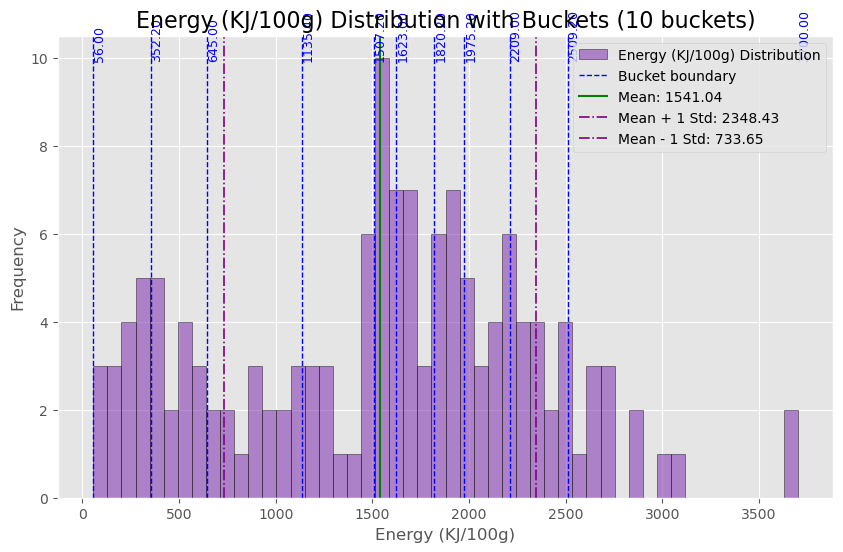

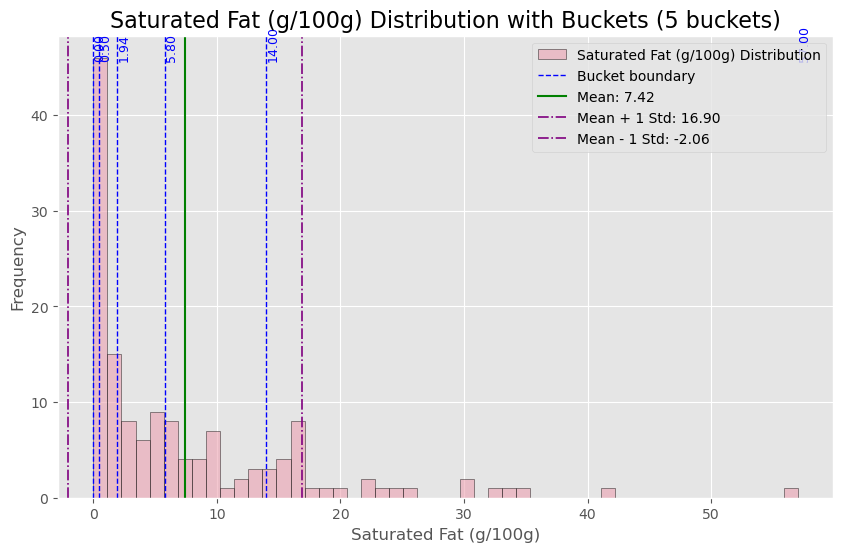

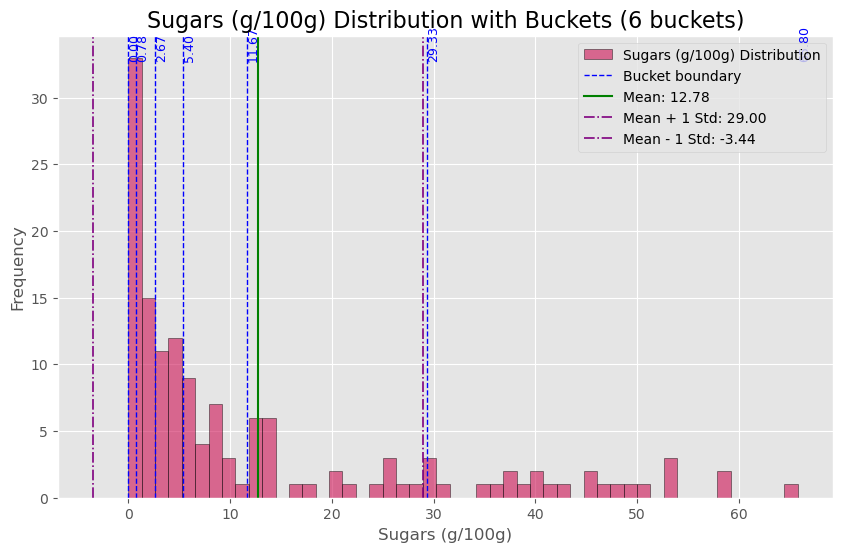

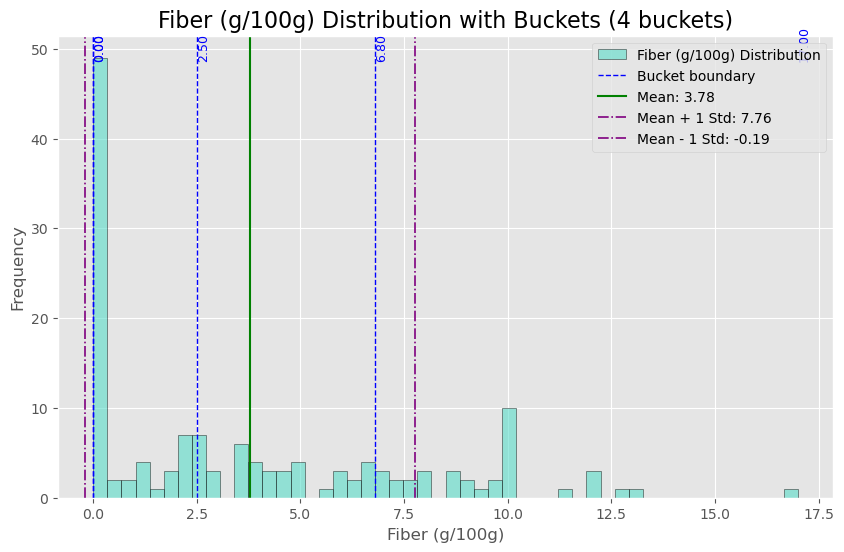

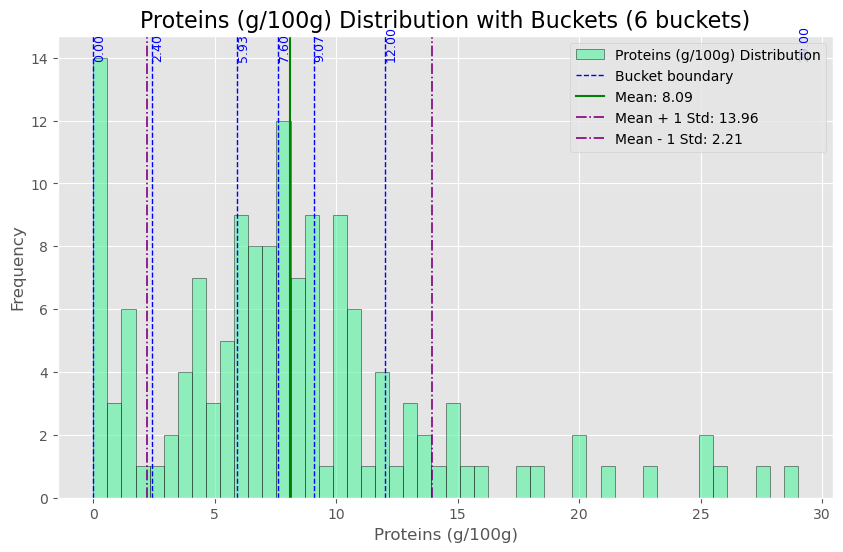

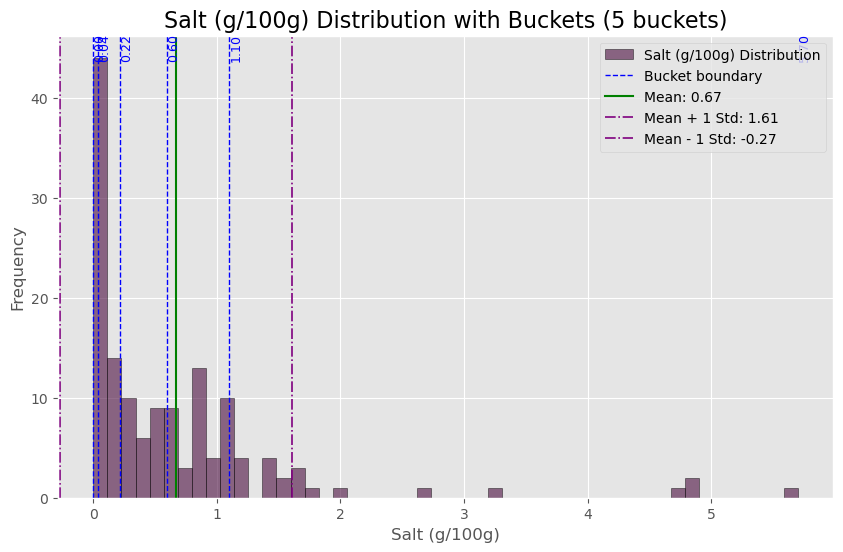

In [11]:
plt.style.use('ggplot')

for feature, feature_buckets in buckets.items():
    plt.figure(figsize=(10, 6))  
    hist_color = np.random.rand(3,)
    data[feature].hist(
        bins=50, alpha=0.6, label=f"{feature} Distribution", color=hist_color, edgecolor='black'
    )

    for i, bucket in enumerate(feature_buckets):
        plt.axvline(
            bucket[0], color='blue', linestyle='--', linewidth=1.0, label="Bucket boundary" if i == 0 else ""
        )
        plt.text(bucket[0], plt.ylim()[1] * 0.95, f"{bucket[0]:.2f}", color='blue', fontsize=9, rotation=90)
    
    plt.text(feature_buckets[-1][1], plt.ylim()[1] * 0.95, f"{feature_buckets[-1][1]:.2f}", color='blue', fontsize=9, rotation=90)

    plt.title(f"{feature} Distribution with Buckets ({len(feature_buckets)} buckets)", fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    mean = data[feature].mean()
    std = data[feature].std()
    plt.axvline(mean, color='green', linestyle='-', linewidth=1.5, label=f"Mean: {mean:.2f}")
    plt.axvline(mean + std, color='purple', linestyle='-.', linewidth=1.2, label=f"Mean + 1 Std: {mean + std:.2f}")
    plt.axvline(mean - std, color='purple', linestyle='-.', linewidth=1.2, label=f"Mean - 1 Std: {mean - std:.2f}")
    plt.legend(fontsize=10)
    plt.show()

In [12]:
prob = LpProblem("Nutriscore", LpMinimize)

sigma = {}

for index, food in data.iterrows():
  sigma[index] = LpVariable("sigma_"+str(index),0, sys.maxsize)

prob += lpSum(list(sigma.values())), "Error in the ranking to be minimized"

utility_limit = {}
for key in buckets:
    utility_limit[key] = []
    
for key in buckets:    
    for i in range(len(buckets[key])):
        utility_limit[key].append(LpVariable(key+"_"+str(i), 0, 1))
    utility_limit[key].append(LpVariable(key+"_"+str(len(buckets[key])), 0, 1))

def get_bucket(value, buckets):
    left, right = 0, len(buckets) - 1
    while left <= right:
        middle = int((right - left) / 2 + left)
        # Check if the value fits in the current bucket
        if buckets[middle][0] <= value < buckets[middle][1]:
            return middle
        # Handle value on the upper edge of the last bucket
        if middle == len(buckets) - 1 and value == buckets[middle][1]:
            return middle
        elif value < buckets[middle][0]:
            right = middle - 1
        else:
            left = middle + 1
    raise ValueError(f"Value {value} is out of bucket bounds: {buckets}")


def get_bucket_recursion(value, buckets, left, right):
    if left > right:  # Add a base case to prevent infinite recursion
        raise ValueError(f"Value {value} is out of bucket bounds: {buckets}")
    
    middle = int((right - left) / 2 + left)
    if buckets[middle][0] <= value < buckets[middle][1]:
        return middle
    # Handle value on the upper edge of the last bucket
    if middle == len(buckets) - 1 and value == buckets[middle][1]:
        return middle
    elif value < buckets[middle][0]:
        return get_bucket_recursion(value, buckets, left, middle - 1)
    else:
        return get_bucket_recursion(value, buckets, middle + 1, right)


def utility_func(data, food_index):
    food = data.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('nutriscore')
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket(food[criterion], buckets[criterion])
        left_thresh = buckets[criterion][bucket_index][0]
        right_thresh = buckets[criterion][bucket_index][1]
        if right_thresh - food[criterion] == 0:
            m = 0  
        else:
            m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_limit[criterion][bucket_index]
        right_utility = utility_limit[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

In [13]:
for index, food in data.iterrows():
    utility_food = utility_func(data, index)
    preceding_foods = data[data['nutriscore'] == food['nutriscore']-1]
    for index2, preceding_food in preceding_foods.iterrows():
        utility_prec_food = utility_func(preceding_foods, index2)
        prob += (utility_food + sigma[index] >= utility_prec_food + sigma[index2] + 0.001)

prob += utility_limit['Energy (KJ/100g)'][len(utility_limit['Energy (KJ/100g)'])-1] == 0
prob += utility_limit['Saturated Fat (g/100g)'][len(utility_limit['Saturated Fat (g/100g)'])-1] == 0
prob += utility_limit['Sugars (g/100g)'][len(utility_limit['Sugars (g/100g)'])-1] == 0
prob += utility_limit['Salt (g/100g)'][len(utility_limit['Salt (g/100g)'])-1] == 0
prob += utility_limit['Proteins (g/100g)'][0] == 0
prob += utility_limit['Fiber (g/100g)'][0] == 0

prob += utility_limit['Energy (KJ/100g)'][0] + \
        utility_limit['Saturated Fat (g/100g)'][0] + \
        utility_limit['Sugars (g/100g)'][0] + \
        utility_limit['Salt (g/100g)'][0] + \
        utility_limit['Proteins (g/100g)'][len(utility_limit['Proteins (g/100g)'])-1] + \
        utility_limit['Fiber (g/100g)'][len(utility_limit['Fiber (g/100g)'])-1] == 1

for i in range(len(utility_limit['Energy (KJ/100g)'])-1):
    prob += utility_limit['Energy (KJ/100g)'][i] >= utility_limit['Energy (KJ/100g)'][i+1]
for i in range(len(utility_limit['Saturated Fat (g/100g)'])-1):
    prob += utility_limit['Saturated Fat (g/100g)'][i] >= utility_limit['Saturated Fat (g/100g)'][i+1]
for i in range(len(utility_limit['Sugars (g/100g)'])-1):
    prob += utility_limit['Sugars (g/100g)'][i] >= utility_limit['Sugars (g/100g)'][i+1]
for i in range(len(utility_limit['Salt (g/100g)'])-1):
    prob += utility_limit['Salt (g/100g)'][i] >= utility_limit['Salt (g/100g)'][i+1]

for i in range(len(utility_limit['Proteins (g/100g)'])-1):
    prob += utility_limit['Proteins (g/100g)'][i] <= utility_limit['Proteins (g/100g)'][i+1]
for i in range(len(utility_limit['Fiber (g/100g)'])-1):
    prob += utility_limit['Fiber (g/100g)'][i] <= utility_limit['Fiber (g/100g)'][i+1]

prob.solve()
print("Status:", LpStatus[prob.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/yutao/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c9ce073d485047c7883f8ba9e8cf1d95-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/c9ce073d485047c7883f8ba9e8cf1d95-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3207 COLUMNS
At line 68168 RHS
At line 71371 BOUNDS
At line 71557 ENDATA
Problem MODEL has 3202 rows, 185 columns and 63998 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3190 (-12) rows, 156 (-29) columns and 58726 (-5272) elements
Perturbing problem by 0.001% of 118.08798 - largest nonzero change 0.00099936906 ( 0.032594928%) - largest zero change 0.0002084295
0  Obj 0 Primal inf 6.7334172 (3160)
51  Obj 0.016560779 Primal inf 83.084434 (1692)
177  Obj 0.14988993 Primal inf 12.58541 (856)
315  Obj 0.21377398 Primal inf 2.407984e-06 (1)
331  Ob

In [14]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, PulpSolverError


def get_bucket(value, buckets):
    """
    Find the bucket index for a given value.
    Adjust for values that are exactly equal to the upper bound of the last bucket.
    """
    # Handle values smaller than the first bucket or larger than the last bucket
    if value < buckets[0][0]:
        return 0  # Assign to the first bucket
    if value > buckets[-1][1]:
        return len(buckets) - 1  # Assign to the last bucket
    
    left, right = 0, len(buckets) - 1
    while left <= right:
        middle = (left + right) // 2
        if buckets[middle][0] <= value <= buckets[middle][1]:  # Include upper bound
            return middle
        elif value < buckets[middle][0]:
            right = middle - 1
        else:
            left = middle + 1
    
    raise ValueError(f"Value {value} is out of bounds for buckets {buckets}")


def compute_utility(food, buckets, utility_thresholds):
    """
    Compute the utility of a food item based on its criteria and bucket thresholds.
    """
    utility = 0
    for criterion, value in food.items():
        if criterion == "nutriscore":
            continue
        try:
            bucket_index = get_bucket(value, buckets[criterion])
        except ValueError as e:
            print(f"ValueError for {criterion}: Value {value} not in buckets {buckets[criterion]}")
            raise e
        
        left_thresh, right_thresh = buckets[criterion][bucket_index]
        if right_thresh - left_thresh == 0:
            slope = 0
        else:
            slope = (value - left_thresh) / (right_thresh - left_thresh)
        
        left_utility = utility_thresholds[criterion][bucket_index]
        right_utility = utility_thresholds[criterion][bucket_index + 1]
        utility += left_utility + slope * (right_utility - left_utility)
    return utility


# Initialize optimization problem
prob = LpProblem("Nutriscore", LpMinimize)

# Create error variables
sigma_vars = {
    index: LpVariable(f"sigma_{index}", 0, None) for index in data.index
}

# Objective: Minimize the total error
prob += lpSum(sigma_vars.values()), "TotalError"

# Create utility thresholds for each criterion
utility_thresholds = {
    key: [LpVariable(f"{key}_{i}", 0, 1) for i in range(len(buckets[key]) + 1)]
    for key in buckets
}

# Add ranking constraints
for index, food in data.iterrows():
    food_utility = compute_utility(food, buckets, utility_thresholds)
    for prev_index, prev_food in data[data['nutriscore'] == food['nutriscore'] - 1].iterrows():
        prev_utility = compute_utility(prev_food, buckets, utility_thresholds)
        prob += (
            food_utility + sigma_vars[index] >= prev_utility + sigma_vars[prev_index] + 0.001
        ), f"RankingConstraint_{index}_{prev_index}"

for key, thresholds in utility_thresholds.items():
    for i in range(len(thresholds) - 1):
        if key in ["Proteins (g/100g)", "Fiber (g/100g)"]:
            prob += thresholds[i] <= thresholds[i + 1], f"Monotonicity_{key}_{i}"
        else:
            prob += thresholds[i] >= thresholds[i + 1], f"Monotonicity_{key}_{i}"


prob += (
    sum(
        thresholds[0] if key in ["Proteins (g/100g)", "Fiber (g/100g)"] else thresholds[-1]
        for key, thresholds in utility_thresholds.items()
    )
    == 1,
    "TotalUtility",
)

# Solve the optimization problem
try:
    prob.solve()
    print("Status:", LpStatus[prob.status])
except PulpSolverError as e:
    print("Solver Error:", e)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/yutao/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ff05ce2b57bb4fb8a1f4c8e05dcd48de-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/ff05ce2b57bb4fb8a1f4c8e05dcd48de-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3201 COLUMNS
At line 69302 RHS
At line 72499 BOUNDS
At line 72542 ENDATA
Problem MODEL has 3196 rows, 185 columns and 64147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3196 (0) rows, 162 (-23) columns and 63319 (-828) elements
Perturbing problem by 0.001% of 42.89522 - largest nonzero change 0.00097077127 ( 0.0022631222%) - largest zero change 0.00096594196
0  Obj 0 Primal inf 4.15584 (3160)
55  Obj 4.629767e-05 Primal inf 145.32805 (1457)
180  Obj 0.071560057 Primal inf 17.293264 (1638)
318  Obj 0.10095331 Primal inf 0.014433996 (371)
327  O

In [15]:
for v in prob.variables():
    print(v.name, "=", v.varValue)

Energy_(KJ_100g)_0 = 0.0010686205
Energy_(KJ_100g)_1 = 0.0010686205
Energy_(KJ_100g)_10 = 0.0
Energy_(KJ_100g)_2 = 0.0010686205
Energy_(KJ_100g)_3 = 0.0010686205
Energy_(KJ_100g)_4 = 0.0010686205
Energy_(KJ_100g)_5 = 0.0
Energy_(KJ_100g)_6 = 0.0
Energy_(KJ_100g)_7 = 0.0
Energy_(KJ_100g)_8 = 0.0
Energy_(KJ_100g)_9 = 0.0
Fiber_(g_100g)_0 = 0.0
Fiber_(g_100g)_1 = 0.0
Fiber_(g_100g)_2 = 0.00050499715
Fiber_(g_100g)_3 = 0.0013733203
Fiber_(g_100g)_4 = 0.0013733203
Proteins_(g_100g)_0 = 0.0
Proteins_(g_100g)_1 = 0.0027302208
Proteins_(g_100g)_2 = 0.0027302208
Proteins_(g_100g)_3 = 0.0034627503
Proteins_(g_100g)_4 = 0.0034627503
Proteins_(g_100g)_5 = 0.0034627503
Proteins_(g_100g)_6 = 0.0038653033
Salt_(g_100g)_0 = 1.0
Salt_(g_100g)_1 = 1.0
Salt_(g_100g)_2 = 1.0
Salt_(g_100g)_3 = 1.0
Salt_(g_100g)_4 = 0.99892135
Salt_(g_100g)_5 = 0.99729602
Saturated_Fat_(g_100g)_0 = 0.0045749019
Saturated_Fat_(g_100g)_1 = 0.0045749019
Saturated_Fat_(g_100g)_2 = 0.0042507309
Saturated_Fat_(g_100g)_3 = 0.00379

In [16]:
utility_thresh_prod = {key: [lpVar.varValue for lpVar in utility_limit[key]]for key in utility_limit}

def utility_func_prod(df, food_index, utility_limit):
    food = df.loc[food_index]
    criteria = [col for col in food.keys() if col != 'nutriscore']
    
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket(food[criterion], buckets[criterion])
        left_thresh, right_thresh = buckets[criterion][bucket_index]
        
        if right_thresh - left_thresh == 0:
            slope = 0
        else:
            slope = (food[criterion] - left_thresh) / (right_thresh - left_thresh)
        
        left_utility = utility_limit[criterion][bucket_index]
        right_utility = utility_limit[criterion][bucket_index + 1]
        
        utility += left_utility + slope * (right_utility - left_utility)
    
    return utility


df_test_sampled = data_test.sample(100)

food_scores = []
for index, food in df_test_sampled.iterrows():
  pred = utility_func_prod(df_test_sampled, index, utility_thresh_prod)
  nutriscore = food['nutriscore']
  food_scores.append({'pred': pred, 'nutriscore': nutriscore})

food_scores.sort(key=lambda food: food['pred'], reverse=True)

food_scores

[{'pred': 1.00516267075215, 'nutriscore': 3.0},
 {'pred': 0.9985406275297805, 'nutriscore': 4.0},
 {'pred': 0.9985092691505568, 'nutriscore': 2.0},
 {'pred': 0.9985022399809841, 'nutriscore': 4.0},
 {'pred': 0.9985016873159721, 'nutriscore': 5.0},
 {'pred': 0.998489004470909, 'nutriscore': 5.0},
 {'pred': 0.998489004470909, 'nutriscore': 5.0},
 {'pred': 0.9984634992413636, 'nutriscore': 5.0},
 {'pred': 0.9984592751206605, 'nutriscore': 5.0},
 {'pred': 0.9984583547891535, 'nutriscore': 5.0},
 {'pred': 0.99844146789305, 'nutriscore': 5.0},
 {'pred': 0.9984394648134994, 'nutriscore': 5.0},
 {'pred': 0.9984304557586721, 'nutriscore': 5.0},
 {'pred': 0.9984207905876555, 'nutriscore': 3.0},
 {'pred': 0.9983971073810914, 'nutriscore': 5.0},
 {'pred': 0.9983802938159952, 'nutriscore': 5.0},
 {'pred': 0.9983789917599551, 'nutriscore': 3.0},
 {'pred': 0.9983757944099999, 'nutriscore': 5.0},
 {'pred': 0.9983757944099999, 'nutriscore': 5.0},
 {'pred': 0.9983206707463437, 'nutriscore': 3.0},
 {'pre